## Table of Contents:
* [1. Variable Selection](#1)
* [1. Analysis](#2)

# Project 2: High-dimensional Linear Models and Convergence in Economic Growth 
*Authors*: Matias Piqueras, Sebastian Hørlück



This notebook contains the analysis code used to generate the tables and figures in project 2. Please note that the code for the different variants of the Lasso are accessed through the class `LassoIV` in the seperate module `highdim.py`.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
import pycountry
import os
import re
import seaborn as sns
from highdim import LassoIV
from sklearn.preprocessing import PolynomialFeatures
plt.style.use('science')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Variable Selection
<a id='0'></a>

As a first step, we analyse missing values for each of the variables in the data-set. 

In [22]:
data = pd.read_csv('data/growth.csv')
labs = pd.read_csv('data/labels.csv')
data['gdp_growth'] = data['gdp_growth'] * 100

In [23]:
print(f'Number of obs. in dataset: {data.shape[0]}')
print(f'Number of obs. with GDP growth (outcome) data: {data.gdp_growth.notna().sum()}')
print(f'Number of obs. with initial GDP (main var) data: {data.lgdp_initial.notna().sum()}')
idx = (data.gdp_growth.notna()) & (data.lgdp_initial.notna())
print(f'Max number of obs. for analysis: {data[idx].shape[0]}')
data_org = data.copy()
data = data_org[idx]

Number of obs. in dataset: 214
Number of obs. with GDP growth (outcome) data: 102
Number of obs. with initial GDP (main var) data: 109
Max number of obs. for analysis: 102


In [46]:
# all available variables
vv_regress = ['gdp_growth', 'lgdp_initial', 'investment_rate']
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'regress': vv_regress,
          'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources,
          'education':vv_educ
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]

In [26]:
# Loop over all variables in data, and allocate to groups based on patterns above
for i in data.columns:
    if i in labs.variable.values:
        res = labs.set_index('variable').loc[[i]].label.values
        if type(res) is np.ndarray:
            res = res[-1]
#         print(f'{i:40s}', res)
        
    for group, group_dict in groups.items():
        if re.search(group_dict['pattern'], res.lower().encode('unicode-escape')) is not None:
            group_dict['vars'].append(i)

# List of all variables put in groups            
grouped_vars = []
for group, group_dict in groups.items():
    grouped_vars += group_dict['vars']

# Print all variables, and the groups they're allocated to
def print_varinfo(variables):
    for i in sorted(variables):
        if i in labs.variable.values:
            res = labs.set_index('variable').loc[[i]].label.values
            if type(res) is np.ndarray:
                res = res[-1]

            in_groups = ''
            for group, group_dict in groups.items():
                if i in group_dict['vars']:
                    in_groups += (group + ', ')
            if in_groups == '':
                in_groups = 'None'
            print(f'{i:40s} {res}')
            print(f'{"":5s} in groups: {in_groups}')

#print_varinfo(data.columns)

In [27]:
for k, v in vv_all.items():
    group_nonmiss = data.notna()[v].all(axis='columns').sum()
    print(f'"{k}" contains the following {len(v)} variables and has {group_nonmiss} non missing values')
    for var in v:
        print(f'{"":10s} {var:30s} ----> {data[var].notna().sum(): 4d} non-missing')

"regress" contains the following 3 variables and has 99 non missing values
           gdp_growth                     ---->  102 non-missing
           lgdp_initial                   ---->  102 non-missing
           investment_rate                ---->   99 non-missing
"institutions" contains the following 5 variables and has 80 non missing values
           marketref                      ---->   84 non-missing
           dem                            ---->   90 non-missing
           demCGV                         ---->   90 non-missing
           demBMR                         ---->   90 non-missing
           demreg                         ---->   99 non-missing
"geography" contains the following 21 variables and has 90 non missing values
           tropicar                       ---->   93 non-missing
           distr                          ---->   93 non-missing
           distcr                         ---->   93 non-missing
           distc                          ---->   93

### Trade-off between variables and observations

Bellow we analyse the trade-off between the amount of variables and observations more closely. Finally, we generate several several dataset which we later use in the analysis.

In [28]:
def keep_nonmiss(n=100, print_mes=False):
    if print_mes:
        print(f'Returning variables with at least {n} observations')
    
    to_keep = []
    groups = [k for k in vv_all.keys() if k != 'all']
    var_groups = np.zeros((1,len(groups)))
    for v in vv_all['all']:
        if data[v].notna().sum() >= n:
            to_keep.append(v)
            for idx, k in enumerate(groups):
                if v in vv_all[k]:
                    var_groups[:,idx] += 1
    return to_keep, var_groups

In [29]:
x_range = range(60,103) # Range of non-missing values
x = [] # List to hold X values
y_var = np.empty((len(x_range),9)) # Array to hold stacked no. of variables
y_obs = [] # List to holder no. of obs.
groups = [i for i in vv_all.keys() if i != 'all'] # Groups for stacked plot

for idx, i in enumerate(x_range): # Loop over range of non-missing
    x.append(i) # Append to x
    y_var_temp = [] # Temp list
    
    res = keep_nonmiss(i)
    
    grp_cnt =  res[1] # Variables with less than i missing values for group k
    
    y_var[idx,:] = grp_cnt # Insert list to array
    temp_vars = res[0] # Variables with less than i missing values for all variable groups
    y_obs.append(data.notna()[temp_vars].all(axis="columns").sum()) # Append number of observations included with variables

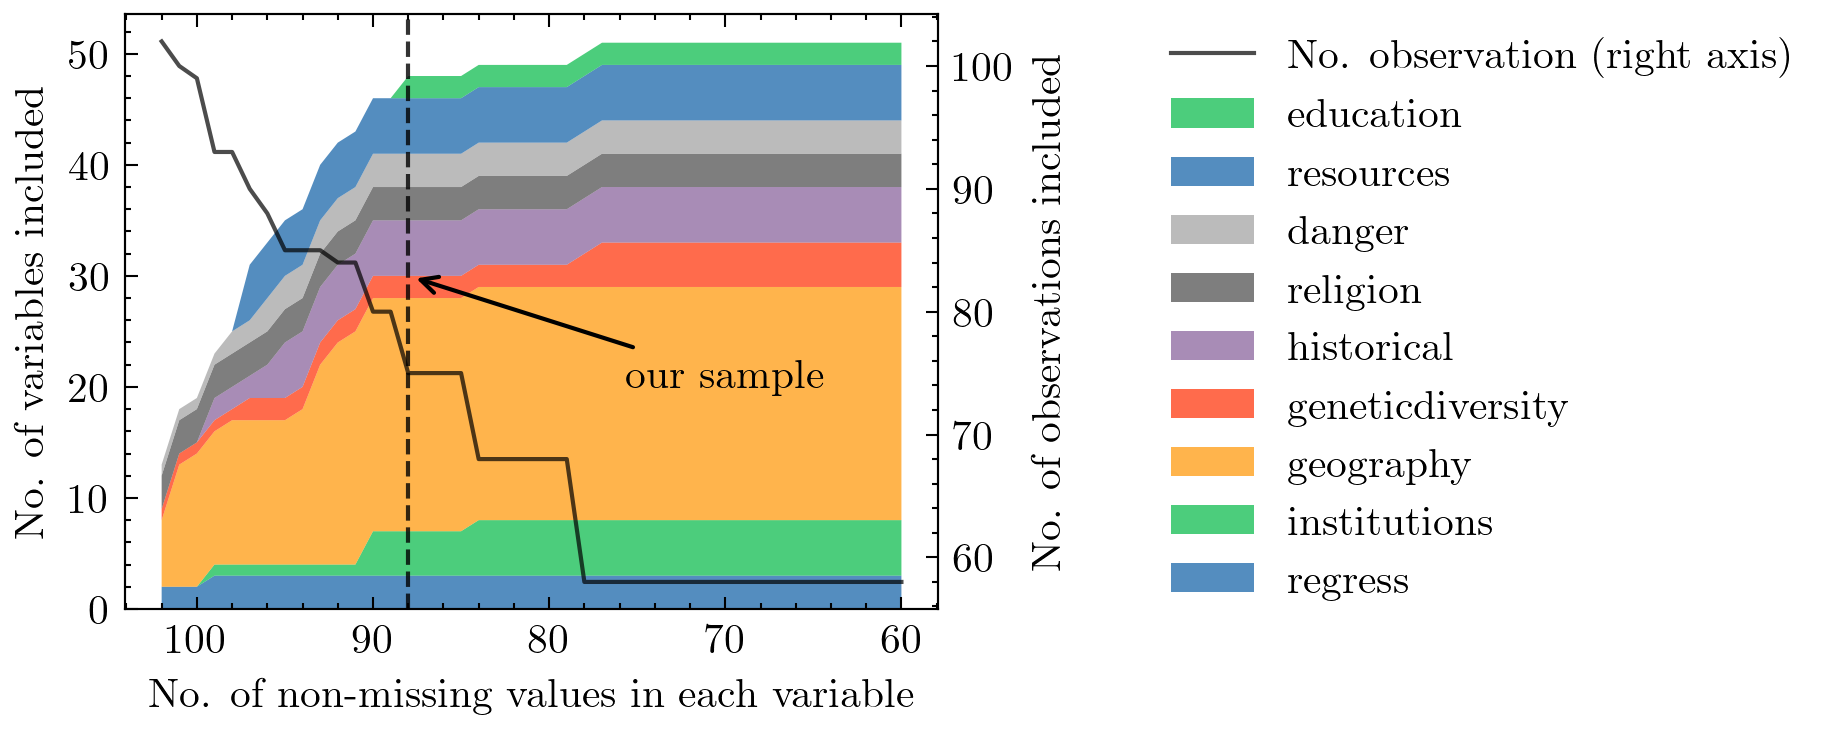

In [30]:
# Create plot for illustratring tradeoff between variables and observations through restriction on non-missing values for each variable
f, ax = plt.subplots(dpi=300) # Figure instance

# Setting up axes
sec_ax = ax.twinx() # Secondary axes 
# Hide grid lines
sec_ax.grid(False)

ax.invert_xaxis() # Invert x-axis

# Adding plots
ax.stackplot(x, y_var.T,labels=groups,alpha=0.7) # Stacked plot of nmber of variables in each group
sec_ax.plot(x,y_obs,color='black',alpha=0.7, label='No. observation (right axis)') # Line plot of number of observations
#ax.axvline(92, color='black',alpha=0.8,linestyle='--')
ax.axvline(88, color='black',alpha=0.8,linestyle='--')

# Adding labels 
handles, labels = ax.get_legend_handles_labels() # Get handles and labels in legend, to reverse the order
handles2, labels2 = sec_ax.get_legend_handles_labels()
handles += handles2; labels += labels2
f.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.75, 0.9)) # Plot reversed order of legend

ax.annotate('our sample', 
             xy=(88,30),xytext=(70, 20), 
                horizontalalignment="center",
                arrowprops=dict(arrowstyle='->',lw=1)
                )

# Adding titles
ax.set_xlabel('No. of non-missing values in each variable')
ax.set_ylabel('No. of variables included')
sec_ax.set_ylabel('No. of observations included')
# Saving figure
fig_path = os.path.join(os.getcwd(),'graphs')
f.set_facecolor('w')
f.savefig(os.path.join(fig_path,'tradeoff.pdf'), bbox_inches='tight')

In [31]:
dfs = dict()
#Create data frames with different amount of variables
for cnt in [102, 95,90, 88, 85, 80]:
    keep = keep_nonmiss(cnt)[0]
    reg_data = data[data[keep].notna().all(axis='columns')][keep].reset_index(drop=True).copy()
    dfs[f'{reg_data.shape[0]}_obs_df'] = reg_data

In [40]:
#The dataset we select
dfs['75_obs_df']

,gdp_growth,lgdp_initial,investment_rate,dem,demCGV,demBMR,demreg,tropicar,distr,distcr,...,yellow,malfal,uvdamage,oilres,goldm,iron,silv,zinc,ls_bl,lh_bl
0,0.410079,8.865619,19.976606,0.0,0.0,0.0,0.071429,0.027089,832.6920,271.6420,...,0.0,0.000000,170.53558,46900.0,0.0,0.0,0.0,0.0,15.300000,4.000000
1,1.548058,10.170480,27.672347,1.0,1.0,1.0,0.954545,0.381887,5188.9000,354.8870,...,1.0,0.000000,223.12234,99100.0,3.0,16.0,9.0,12.0,48.300000,21.500000
2,1.767717,9.881951,25.954993,1.0,1.0,1.0,0.954545,0.000000,81.3668,79.4891,...,0.0,0.000000,87.99640,11900.0,0.0,0.0,0.0,0.0,35.800000,2.600000
3,-0.527589,5.574601,10.887358,0.0,0.0,0.0,0.032258,1.000000,1860.0400,1009.6600,...,1.0,1.000000,272.06750,0.0,0.0,0.0,0.0,0.0,0.912563,0.141201
4,1.625661,9.893827,23.671420,1.0,1.0,1.0,0.954545,0.000000,53.2518,38.3926,...,0.0,0.000000,70.60848,0.0,0.0,0.0,0.0,0.0,28.700000,5.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2.599004,8.347832,21.024582,1.0,1.0,1.0,0.000000,0.000000,675.9640,160.4680,...,0.0,0.000000,139.25563,7970.0,0.0,0.0,0.0,0.0,6.085606,1.325752
71,1.693909,10.052219,22.008796,1.0,1.0,1.0,0.954545,0.001515,1280.4900,446.1540,...,1.0,0.000000,131.59421,95700.0,11.0,6.0,11.0,13.0,59.314404,21.300000
72,0.155414,8.739389,22.211417,0.0,0.0,0.0,0.032258,0.037754,1020.6400,306.8910,...,0.0,0.022699,213.88030,0.0,47.0,4.0,0.0,2.0,27.400002,3.700000
73,-0.028674,7.365705,36.330155,0.0,0.0,0.0,0.032258,1.000000,1196.5000,992.1960,...,1.0,1.000000,272.77466,0.0,0.0,0.0,0.0,0.0,1.900000,0.600000


In [47]:
labs

,variable,label,source
0,country_name,Country name,ANRR
1,wbcode,World Bank country code,ANRR
2,year,Year (from 1960 to 2010),ANRR
3,gdppercapitaconstant2000us,"GDP per capita (constant 2000 US$, from World ...",ANRR
4,lp_bl,Percentage of population with at most primary ...,ANRR
...,...,...,...
376,lgdp_now,GDP per capita in 2020 (log),WB
377,lpop_initial,Population in 1970 (log),WB
378,lpop_now,Population in 2020 (log),WB
379,gdp_growth,"Annual growth in GDP per capita, 1970-2020",WB


In [44]:
vals = []
for cat, val_names in vv_all.items():
    if cat != 'all':
        for val in val_names:
            if val in dfs['75_obs_df'].columns:
                vals.append([cat, val])

In [52]:
#List all variables
print(pd.DataFrame(vals, columns=['category', 'variable'])\
      .merge(labs).drop(['source'],axis=1)\
      .set_index('category').to_latex())

\begin{tabular}{lll}
\toprule
{} &         variable &                                              label \\
category         &                  &                                                    \\
\midrule
regress          &       gdp\_growth &         Annual growth in GDP per capita, 1970-2020 \\
regress          &     lgdp\_initial &                       GDP per capita in 1970 (log) \\
regress          &  investment\_rate &  Capital formation (\% of GDP per year, avg. of ... \\
institutions     &              dem &                          Democracy measure by ANRR \\
institutions     &           demCGV &                           Democracy measure by CGV \\
institutions     &           demBMR &                           Democracy measure by BMR \\
institutions     &           demreg &  Average democracy in the region*initial regime... \\
geography        &         tropicar &                \% land area in geographical tropics \\
geography        &            distr &             

### Missing Countries

Here we analyse which countries are missing from the the data-frame with 75 observations and  48 variables. 

In [13]:
#Add country code variable and get missing countries
geo75 = dfs['75_obs_df'].merge(data[['lgdp_initial', 'code']], on='lgdp_initial')
missing_countries = list(set(data['code']) - set(geo75['code']))

#Get country names
country_info = [[c.alpha_3, c.name] for c in pycountry.countries]
missing_df = pd.DataFrame([c for c in country_info if c[0] in missing_countries],
                          columns=['code', 'country'])
#Get continent names
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU': 'Europe'
}
missing_df['continent'] = [continents[country_alpha2_to_continent_code(country_name_to_country_alpha2(country))] 
                           for country in missing_df['country']]

print('Countries missing from our sample:')
print('-'*45)
missing_df.sort_values('continent')

Countries missing from our sample:
---------------------------------------------


,code,country,continent
0,BFA,Burkina Faso,Africa
23,TCD,Chad,Africa
22,SYC,Seychelles,Africa
21,SWZ,Eswatini,Africa
16,NGA,Nigeria,Africa
15,MWI,Malawi,Africa
7,GNB,Guinea-Bissau,Africa
13,MDG,Madagascar,Africa
9,HKG,Hong Kong,Asia
1,BGD,Bangladesh,Asia


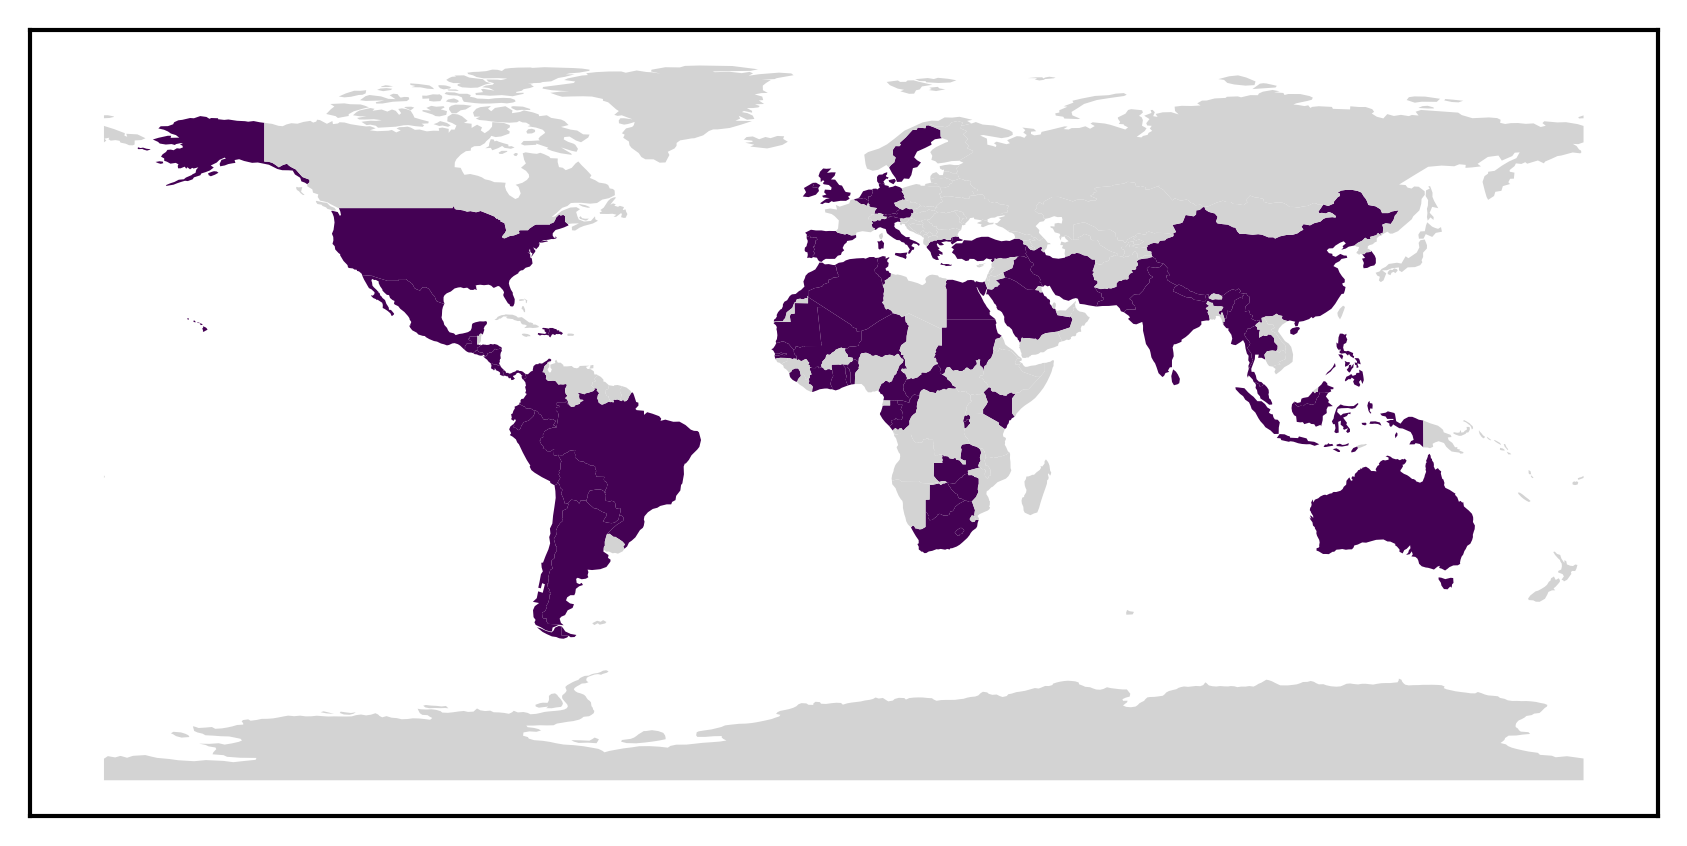

In [14]:
#plot map of countries included
world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres'))

world['insample'] = world['iso_a3'].apply(lambda x: 1 if x in geo75['code'].tolist() 
                                          else np.nan)

fig, ax = plt.subplots(dpi=600)
world.plot(column = 'insample',
           ax = ax,
           missing_kwds={
            "color": "lightgrey",
        })

ax.set_xticks([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticks([])
plt.savefig('graphs/map.eps',  format='eps')

## Analysis

In this section we perform fit the models to our data. First we focus on the selected sample to produce the results as displayed in text. Next, we also run the models on the different subsamples as created above. We also test the BRT method for lambda and not using polynomials and interactions.

In [15]:
#Prepare data
poly = PolynomialFeatures(2)
fit = poly.fit(dfs['75_obs_df'].drop(['gdp_growth', 'lgdp_initial'], axis  = 1))
X = pd.DataFrame(poly.fit_transform(dfs['75_obs_df'].drop(['gdp_growth', 'lgdp_initial'], axis  = 1)), columns=fit.get_feature_names())
analysis_data = pd.concat([dfs['75_obs_df'][['gdp_growth', 'lgdp_initial']], X], axis = 1)

In [16]:
ppol_main = LassoIV(y = 'gdp_growth', d = 'lgdp_initial', data = analysis_data,
          estimator='ppol', lamb_method='bcch', c=1.1).fit(significant_lvl=0.05)

For gdp_growth ~ Z
The Belloni-Chen-Chernozhukov-Hansen lambda is: 3.77743
For lgdp_initial ~ Z
The Belloni-Chen-Chernozhukov-Hansen lambda is: 5.36161
Number of non-zero controls y ~ Z: 0
Number of non-zero controls d ~ Z: 0
lgdp_initial estimate: -0.16573
Confidence interval: [-0.43019  0.09873]


In [17]:
pdl_main = LassoIV(y = 'gdp_growth', d = 'lgdp_initial', data = analysis_data,
          estimator='pdl', lamb_method='bcch', c=1.1).fit(significant_lvl=0.05)

For gdp_growth ~ Z
The Belloni-Chen-Chernozhukov-Hansen lambda is: 3.77743
For lgdp_initial ~ Z
The Belloni-Chen-Chernozhukov-Hansen lambda is: 5.36161
For gdp_growth ~ X
The Belloni-Chen-Chernozhukov-Hansen lambda is: 3.77762
Number of non-zero controls y ~ Z: 0
Number of non-zero controls d ~ Z: 0
Number of non-zero controls y ~ X: 0
lgdp_initial estimate: -0.16573
Confidence interval: [-0.43019  0.09873]


### Other subsamples and using bort BCCH and BRT

In [18]:
def model_compare(dfs:dict, polynomial_features = False):
    for name, data in dfs.items():
        if polynomial_features:
            poly = PolynomialFeatures(2)
            fit = poly.fit(data.drop(['gdp_growth', 
                                      'lgdp_initial'], 
                                        axis = 1))
            X = pd.DataFrame(poly.fit_transform(data.drop(['gdp_growth', 
                                                            'lgdp_initial'],
                                                            axis  = 1)), 
                             columns=fit.get_feature_names())
            data = pd.concat([data[['gdp_growth', 'lgdp_initial']], X], axis = 1)
        print('-'*66)
        print(f'DATASET: {data.shape[0]} OBSERVATIONS AND  {data.shape[1]} VARIABLES')
        print('-'*66)
        print('PDL AND BRT')
        print('-'*66)
        LassoIV(y = 'gdp_growth', d = 'lgdp_initial', data = data,
              estimator='pdl', lamb_method='brt', c=1.1).fit(significant_lvl=0.05)
        print('-'*66)
        print('PDL AND BCCH')
        print('-'*66)
        LassoIV(y = 'gdp_growth', d = 'lgdp_initial', data = data,
              estimator='pdl', lamb_method='bcch', c=1.1).fit(significant_lvl=0.05)
        print('-'*66)
        print('PPOL AND BRT')
        print('-'*66)
        LassoIV(y = 'gdp_growth', d = 'lgdp_initial', data = data,
              estimator='ppol', lamb_method='brt', c=1.1).fit(significant_lvl=0.05)
        print('-'*66)
        print('PPOL AND BCCH')
        print('-'*66)
        LassoIV(y = 'gdp_growth', d = 'lgdp_initial', data = data,
              estimator='ppol', lamb_method='bcch', c=1.1).fit(significant_lvl=0.05)

In [19]:
#Compare models not including polynomials
model_compare(dfs, polynomial_features=False)

------------------------------------------------------------------
DATASET: 102 OBSERVATIONS AND  13 VARIABLES
------------------------------------------------------------------
PDL AND BRT
------------------------------------------------------------------
For gdp_growth ~ Z
The Bickel-Ritov-Tsybakov lambda is: 0.4487
For lgdp_initial ~ Z
The Bickel-Ritov-Tsybakov lambda is: 0.42147
For gdp_growth ~ X
The Bickel-Ritov-Tsybakov lambda is: 0.45307
Number of non-zero controls y ~ Z: 1
Number of non-zero controls d ~ Z: 2
Number of non-zero controls y ~ X: 1
lgdp_initial estimate: -0.20826
Confidence interval: [-0.53816  0.12165]
------------------------------------------------------------------
PDL AND BCCH
------------------------------------------------------------------
For gdp_growth ~ Z
The Belloni-Chen-Chernozhukov-Hansen lambda is: 1.23262
For lgdp_initial ~ Z
The Belloni-Chen-Chernozhukov-Hansen lambda is: 2.71363
For gdp_growth ~ X
The Belloni-Chen-Chernozhukov-Hansen lambda is: 

In [20]:
model_compare(dfs, polynomial_features=True)

------------------------------------------------------------------
DATASET: 102 OBSERVATIONS AND  80 VARIABLES
------------------------------------------------------------------
PDL AND BRT
------------------------------------------------------------------
For gdp_growth ~ Z
The Bickel-Ritov-Tsybakov lambda is: 0.53978
For lgdp_initial ~ Z
The Bickel-Ritov-Tsybakov lambda is: 0.50703
For gdp_growth ~ X
The Bickel-Ritov-Tsybakov lambda is: 0.54033
Number of non-zero controls y ~ Z: 1
Number of non-zero controls d ~ Z: 1
Number of non-zero controls y ~ X: 1
lgdp_initial estimate: -0.19116
Confidence interval: [-0.5154   0.13308]
------------------------------------------------------------------
PDL AND BCCH
------------------------------------------------------------------
For gdp_growth ~ Z
The Belloni-Chen-Chernozhukov-Hansen lambda is: 2.52706
For lgdp_initial ~ Z
The Belloni-Chen-Chernozhukov-Hansen lambda is: 3.767
For gdp_growth ~ X
The Belloni-Chen-Chernozhukov-Hansen lambda is: 2